
### If you have questions or issues you can send emails to Iman or John. 

### 1-Install Flywheel SDK and Gear Toolkit

In [ ]:
pip install flywheel_gear_toolkit flywheel-sdk~=16.10.3

### Dicom 2 NIfTI: here we are converting all the Dicom files to NIfTI.

You need to pass the project name and API_Key. You can get API_KEY from the profile in your FlyWheel account.

Before running this, you need to go to Gear Rules in Flywheel and do some small modifications:  Go to your project, click on "three dots" next to the Data Views, select Gear rules, click on dcm2niix, make sure to **DEELET** *EXCEPT if the data matches ANY of the following criteria* part and also *the clissifcation* part and save the changes.
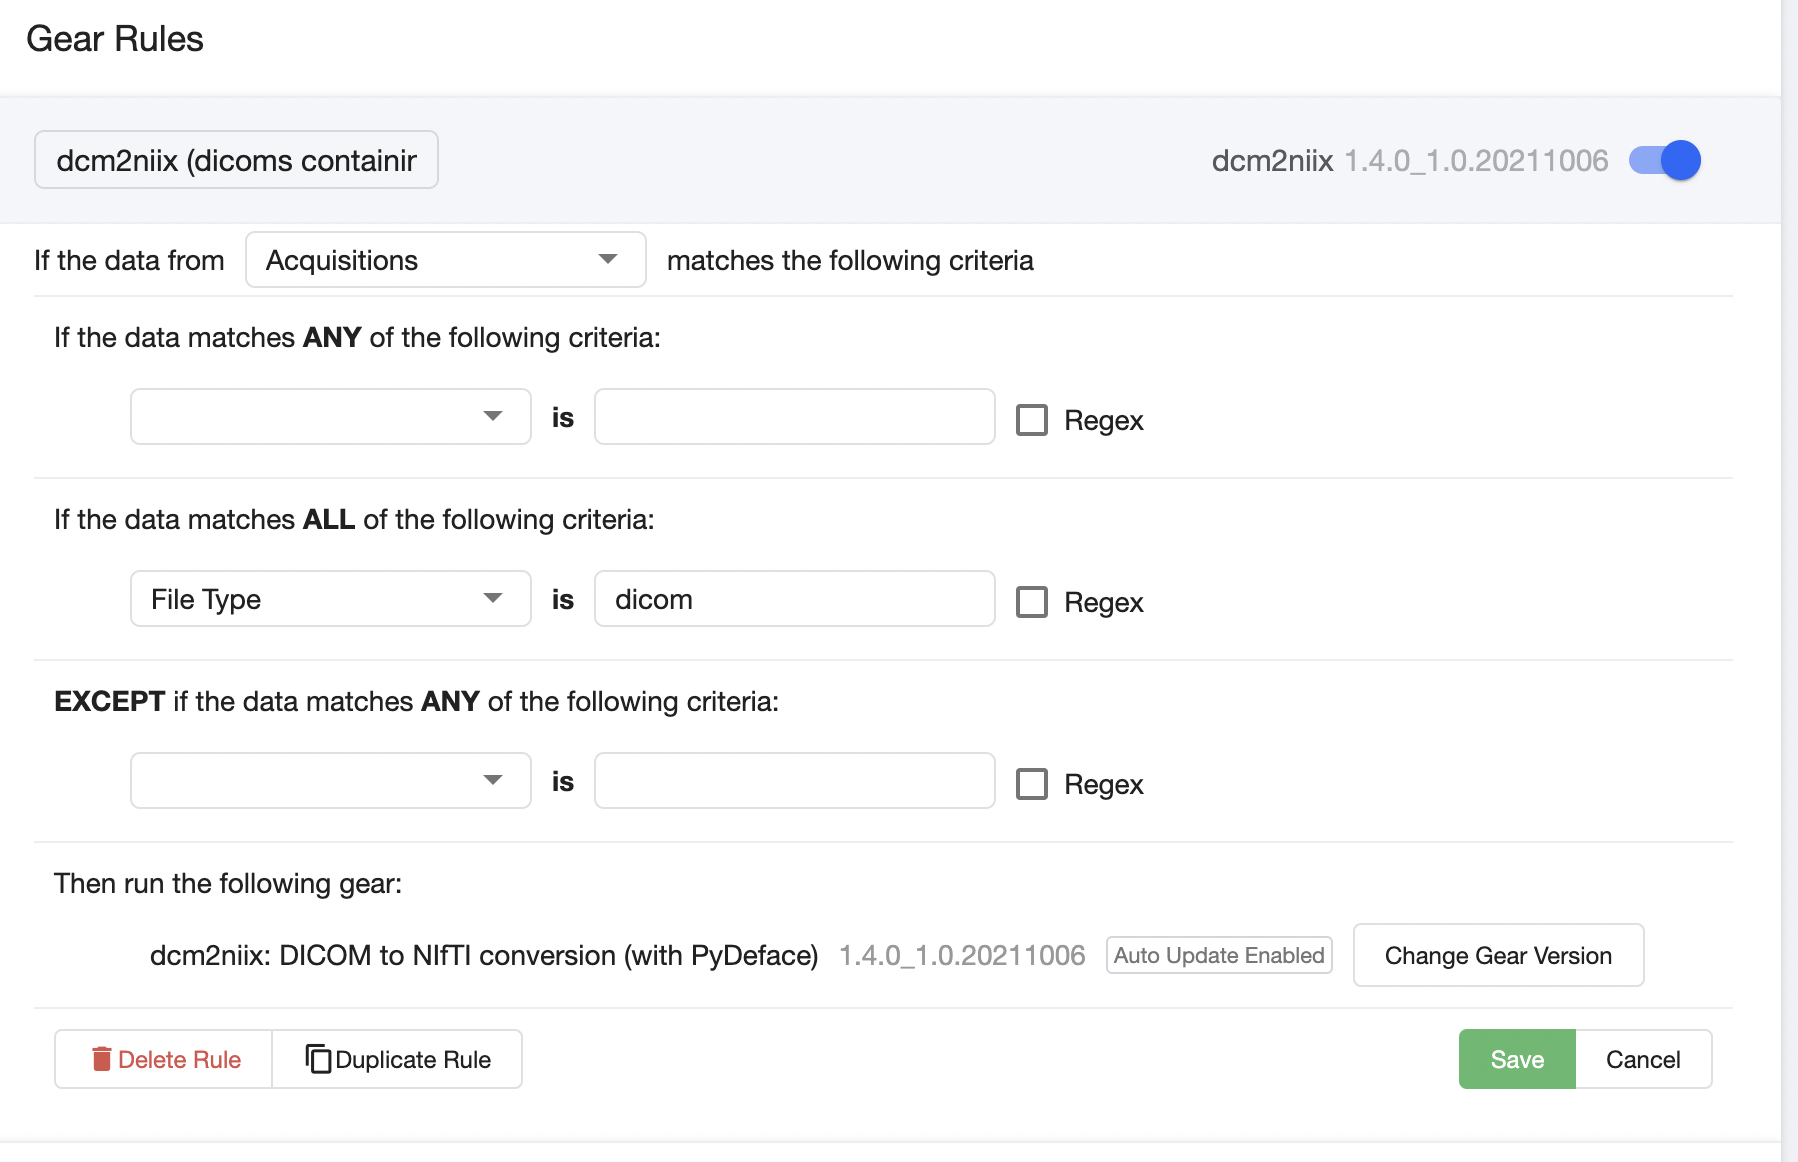
After this step please check if all the dicom files are converted to NIfTI

In [ ]:
%run 1-batch-set-and-trigger-gear-rules.py --group "siimfedlearn" --project "Backup_Phase_1_Site_5" --api-key ...

You must wait until each step is complete. If all goes as expected, Every session in the provenance tab will resemble the image below:
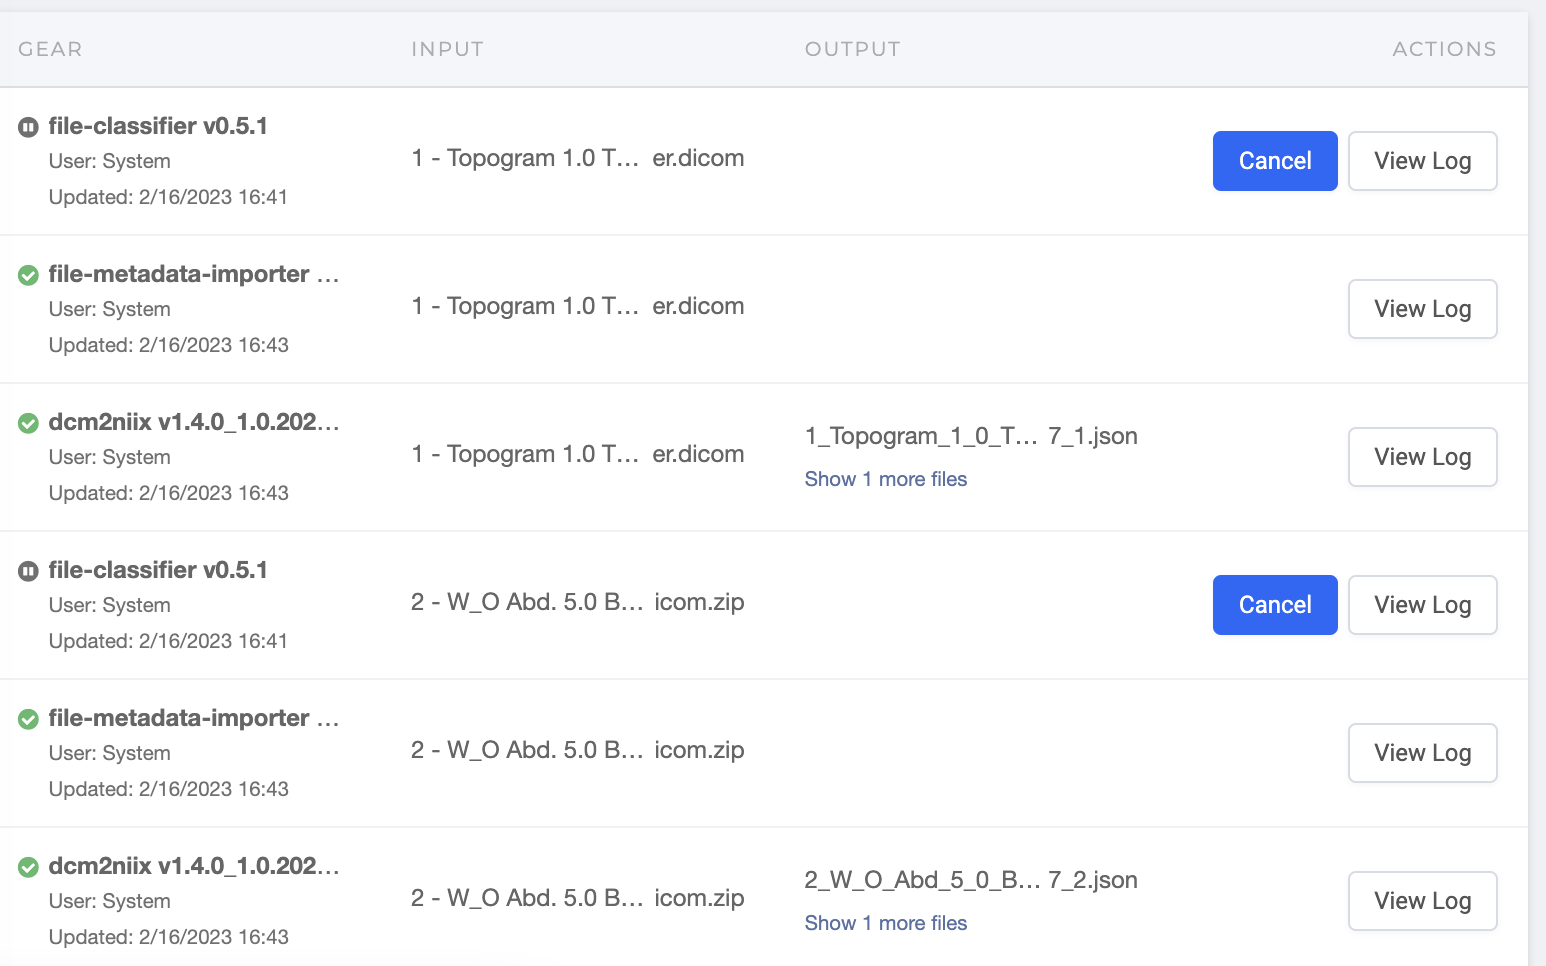

### ROI2NIX

In [ ]:
%run 2-batch-run-roi2nix.py --group "siimfedlearn" --project "Backup_Phase_1_Site_5" --api-key ...

### Add source on ref

In [ ]:
%run 3-add-source-ref-on-mask.py --group "siimfedlearn" --project "Backup_Phase_1_Site_5" --api-key ...

### Download

Just specify the output folder as well as the project neme and API KEY.

In [ ]:


%run 4-download-mask-and-source_V2.py --output "/src/workspace/BTCV/Site_5_Test/" --group "siimfedlearn" --project "Backup_Phase_1_Site_5" --api-key ...

### Data for Training

Here, we created a small script that verifies/creates the data and labels in a format that can be used for training. It also creates a.json file with all the details of the downloaded data, such as the subject, session, and other information connected to the downloaded files.

In [ ]:
import os
import shutil 
import nibabel as nib
import sys
import json


## Put the output directory Here(ATTENTION: It should be the same as what you entered above to download the files to):
dir_0 = "/src/workspace/BTCV/Site_5_Test/"
dir_1 = dir_0 + "For_FedTraining"

if not os.path.exists(dir_1):
    os.mkdir(dir_1)
    
data = dir_1 + '/data/'
if not os.path.exists(data):
    os.mkdir(data)
    
labels = dir_1 + '/labels/'
if not os.path.exists(labels):
    os.mkdir(labels)
    
def save_pet(pet, filename):
    with open(filename, 'w') as f:
        f.write(json.dumps(pet))    
    
"""
data_test = dir_1 + '/data_test/'
if not os.path.exists(data_test):
    os.mkdir(data_test)    
    
labels_test = dir_1 + '/labels_test/'
if not os.path.exists(labels_test):
    os.mkdir(labels_test)    
"""      
    
def splitall(path):
    allparts = []
    while 1:
        parts = os.path.split(path)
        if parts[0] == path:  # sentinel for absolute paths
            allparts.insert(0, parts[0])
            break
        elif parts[1] == path: # sentinel for relative paths
            allparts.insert(0, parts[1])
            break
        else:
            path = parts[0]
            allparts.insert(0, parts[1])
    return allparts    
    
   

data_id = 1


Dic = {}
saved_num = 0
for root, dirs, files in os.walk(dir_0):
    if "source" in root:
        for root, dirs, files_source in os.walk(root):
            if not files_source:
               print(f' Does not have the Data: {root}', file=sys.stderr)

            else:    
                for file_source in files:
                    print(f'\n************* {data_id}   \n\n')
                    print(root+'/'+file_source)
                    str1 = root
                    root_mask = str1.replace('source','mask')
                    for root_mask, dirs_mask, files_mask in os.walk(root_mask): 
                        if not files_mask:
                            print(f' Does not have the label: {root_mask}', file=sys.stderr)

                        else:    
                            for file_mask in files_mask: 
                                
                                Dic[data_id]={}
                                
                                
                                print(root_mask+'/'+file_mask)

                                # rename Source: data
                                temp_img_source = nib.load(root+'/'+file_source)
                                
                                
                                
                                
                                source_shape = temp_img_source.get_fdata().shape
                                print(f'source.shape={temp_img_source.get_fdata().shape}')
                                print(f'source.ndim={temp_img_source.get_fdata().ndim}')
                                temp_img_source_pix_dim = temp_img_source.header.get_zooms()[:3]
                                print(f'source.pixdim={temp_img_source_pix_dim}')



                                
                                #shutil.copy(root+'/'+file_source, data_test + file_source)

                                # rename mask: label
                                temp_img_mask = nib.load(root_mask+'/'+file_mask) 
                                print(f'label.shape={temp_img_mask.get_fdata().shape}')
                                print(f'source.ndim={temp_img_mask.get_fdata().ndim}')
                                mask_shape = temp_img_mask.get_fdata().shape
                                temp_img_mask_pix_dim = temp_img_mask.header.get_zooms()[:3]
                                print(f'mask.pixdim={temp_img_mask_pix_dim}')
                                
                                #shutil.copy(root_mask+'/'+file_mask, labels_test + file_mask)
                                
                                if source_shape!=mask_shape:
                                      print(f'!!!!! Error the shapes are not equal')
                                      Dic[data_id][ 'error_in_shape'] = {} 
                                    
                                      Dic[data_id][ 'error_in_shape']["has it?"] = "true"
                                      Dic[data_id]["source_shape"] = source_shape
                                      Dic[data_id]["mask_shape"] = mask_shape
                                        
                                        
                                elif temp_img_source.get_fdata().ndim != temp_img_mask.get_fdata().ndim:
                                      print(f'!!!!! wired dimensions') 
                                      Dic[data_id][ 'error_in_shape'] = {} 
                                    
                                      Dic[data_id][ 'error_in_shape']["has it?"] = "true"
                                      Dic[data_id]["source_shape"] = source_shape
                                      Dic[data_id]["mask_shape"] = mask_shape  
                                        
                                elif  ((temp_img_source.get_fdata().ndim != 3) | (temp_img_mask.get_fdata().ndim != 3)):   
                                      print(f'!!!!! wired dimensions')
                                      Dic[data_id][ 'error_in_shape'] = {} 
                                    
                                      Dic[data_id][ 'error_in_shape']["has it?"] = "true"
                                      Dic[data_id]["source_shape"] = source_shape
                                      Dic[data_id]["mask_shape"] = mask_shape
                                        
                               
                                    
                                elif "Eq" not in file_mask:
                                    print(f'\n\n data #num={data_id} is saved!')
                                    Dic[data_id][ 'error_in_shape'] = {} 
                                    
                                    Dic[data_id][ 'error_in_shape']["has it?"] = "false"
                                    
                                    
                                    saved_num +=1
                                    nib.save(temp_img_source,  data + str(data_id) + '.nii')
                                    nib.save(temp_img_mask,  labels + str(data_id) + '.nii')
                                    
                                ## Dictionary
                                path = splitall(root)
                                
                                
                                Dic[data_id][ 'path_source'] = root+'/'+file_source
                                Dic[data_id][ 'path_mask'] = root_mask+'/'+file_mask
                                Dic[data_id][ 'subj'] = path[2]
                                Dic[data_id][ 'session'] = path[3]
                                Dic[data_id][ 'acq'] = path[4]
                                
                                data_id += 1 

                            
                            
save_pet(Dic, dir_1 +'/info.json')                          